# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** [Rizky Yanuar Kristianto]
- **Email:** [rizky.22017@mhs.unesa.ac.id]
- **ID Dicoding:** [rizkyyanuark]

## Menentukan Pertanyaan Bisnis

- Pertanyaan 1: How does a delay in shipping (from the carrier to the customer) impact customer satisfaction and review scores?
- Pertanyaan 2: How has the sales revenue evolved over time for different regions, and which regions show the highest growth or decline?
- Pertanyaan 3: Which areas have the highest incidence of delivery delays?

## Import Semua Packages/Library yang Digunakan

In [2]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
import json

## Data Wrangling

### Gathering Data

In [3]:
# Importing Datasets
df_item = pd.read_csv("data/olist_order_items_dataset.csv")
df_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("data/olist_orders_dataset.csv")
df_products = pd.read_csv("data/olist_products_dataset.csv")
df_geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
df_sellers = pd.read_csv("data/olist_sellers_dataset.csv")
df_order_pay = pd.read_csv("data/olist_order_payments_dataset.csv")
df_customers = pd.read_csv("data/olist_customers_dataset.csv")
df_category = pd.read_csv("data/product_category_name_translation.csv")

In [4]:
# Merging Datasets
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

**Insight:**
- Consolidate the datasets into a single main datase

### Assessing Data

In [5]:
# Mengonversi kolom 'order_purchase_timestamp' menjadi tipe datetime
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'])

# Menambahkan kolom baru berdasarkan 'order_purchase_timestamp'
df_train['day_of_week_name'] = df_train['order_purchase_timestamp'].dt.strftime('%A')
df_train['month_year'] = df_train['order_purchase_timestamp'].dt.strftime('%Y %m')
df_train['day_month_year'] = df_train['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')
df_train['day_of_week_int'] = df_train['order_purchase_timestamp'].dt.weekday + 1
df_train['hour'] = df_train['order_purchase_timestamp'].dt.hour
df_train['month'] = df_train['order_purchase_timestamp'].dt.month
df_train['year'] = df_train['order_purchase_timestamp'].dt.year
df_train['date'] = df_train['order_purchase_timestamp'].dt.to_period('M')
df_train['datetime'] = df_train['order_purchase_timestamp']

# Mengonversi kolom 'order_delivered_customer_date' menjadi tipe datetime
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date'])
df_train['day_month_year_delivered'] = df_train['order_delivered_customer_date'].dt.strftime('%Y-%m-%d')
df_train['day_month_year_delivered'] = pd.to_datetime(df_train['day_month_year_delivered'])
df_train['day_month_year'] = pd.to_datetime(df_train['day_month_year'])

# Menghitung waktu pengiriman dalam hari
df_train['delivery_time'] = (df_train['order_delivered_customer_date'] - df_train['order_purchase_timestamp']).dt.days

### Cleaning Data

In [6]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def cross_heatmap(df, cols, normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]], 
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)

In [7]:
def summarize_table(df):
    print(f"Shape of Dataset: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['Data Types'])
    summary = summary.reset_index()
    summary['Column Name'] = summary['index']
    summary = summary[['Column Name', 'Data Types']]
    summary['Missing Values'] = df.isnull().sum().values    
    summary['Unique Values'] = df.nunique().values
    summary['First Entry'] = df.iloc[0].values
    summary['Second Entry'] = df.iloc[1].values
    summary['Third Entry'] = df.iloc[2].values

    for col in summary['Column Name'].value_counts().index:
        summary.loc[summary['Column Name'] == col, 'Entropy'] = round(stats.entropy(df[col].value_counts(normalize=True), base=2), 2)

    return summary

def generate_cross_heatmap(df, columns, normalize=False, values=None, aggfunc=None):
    selected_columns = columns
    color_map = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[selected_columns[0]], df[selected_columns[1]], 
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap=color_map)

In [8]:
resumetable(df_train)

Dataset Shape: (119143, 50)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,99441,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,16.46
1,customer_id,object,0,99441,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,16.46
2,order_status,object,0,8,delivered,delivered,delivered,0.25
3,order_purchase_timestamp,datetime64[ns],0,98875,2017-10-02 10:56:33,2017-10-02 10:56:33,2017-10-02 10:56:33,16.44
4,order_approved_at,object,177,90733,2017-10-02 11:07:15,2017-10-02 11:07:15,2017-10-02 11:07:15,16.28
5,order_delivered_carrier_date,object,2086,81018,2017-10-04 19:55:00,2017-10-04 19:55:00,2017-10-04 19:55:00,16.03
6,order_delivered_customer_date,datetime64[ns],3421,95664,2017-10-10 21:25:13,2017-10-10 21:25:13,2017-10-10 21:25:13,16.40
7,order_estimated_delivery_date,object,0,459,2017-10-18 00:00:00,2017-10-18 00:00:00,2017-10-18 00:00:00,8.47
8,order_item_id,float64,833,21,1.0,1.0,1.0,0.72
9,product_id,object,833,32951,87285b34884572647811a353c7ac498a,87285b34884572647811a353c7ac498a,87285b34884572647811a353c7ac498a,13.63


**Insight:**
- Adjust the order and delivery dates for the products (Completed)
- Generate a summary table detailing each feature, including size, name, type, null values, unique values, and entropy (Completed)

## Exploratory Data Analysis (EDA)

### Explore parameter statistik

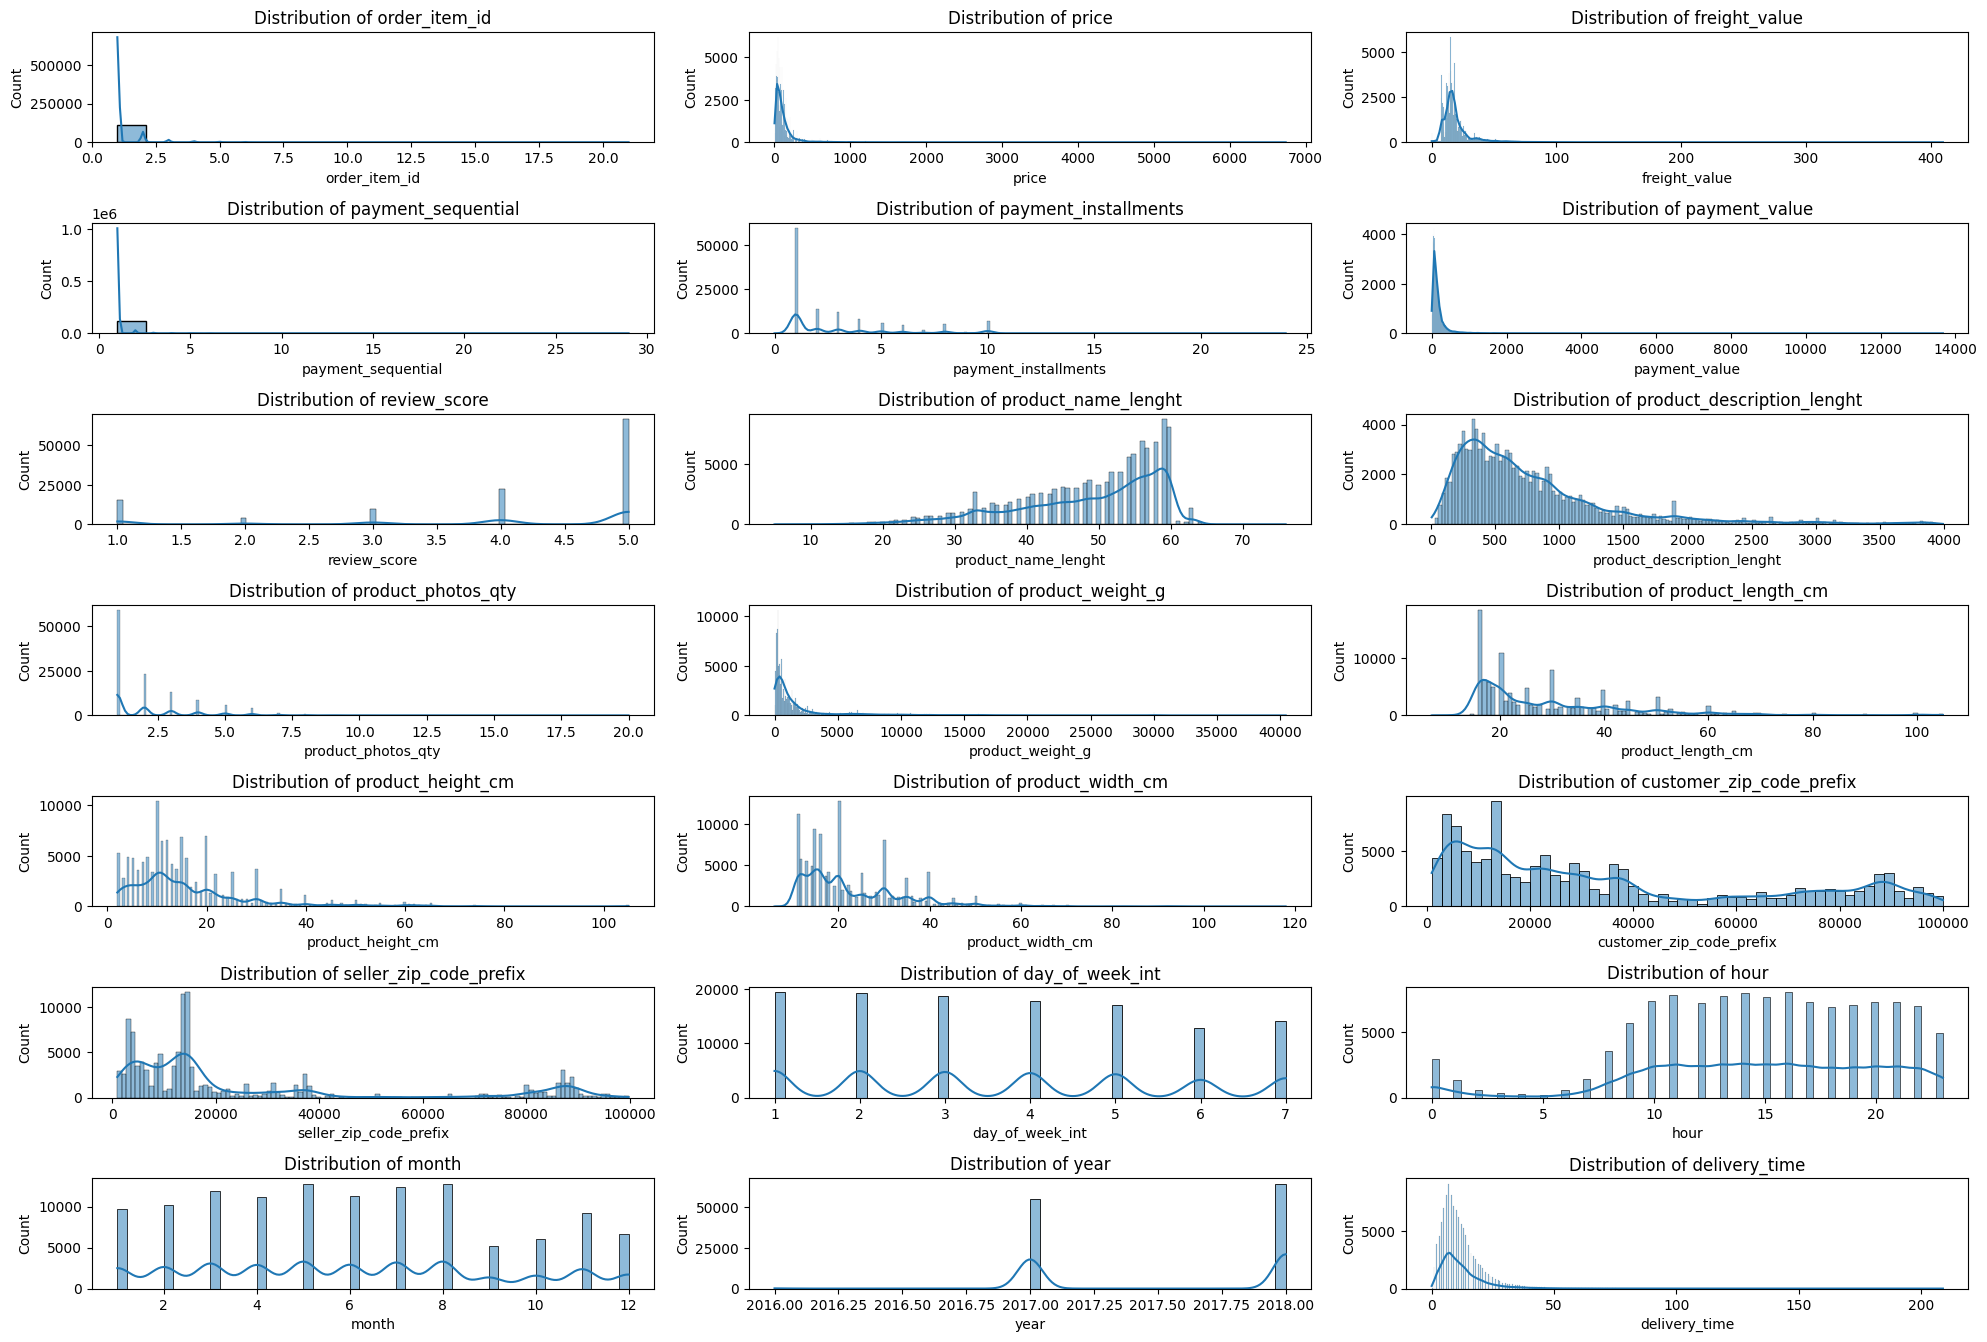

In [9]:
# Distribution of Numerical Features
numerical_features = df_train.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(len(numerical_features) // 3 + 1, 3, i + 1)
    sns.histplot(df_train[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

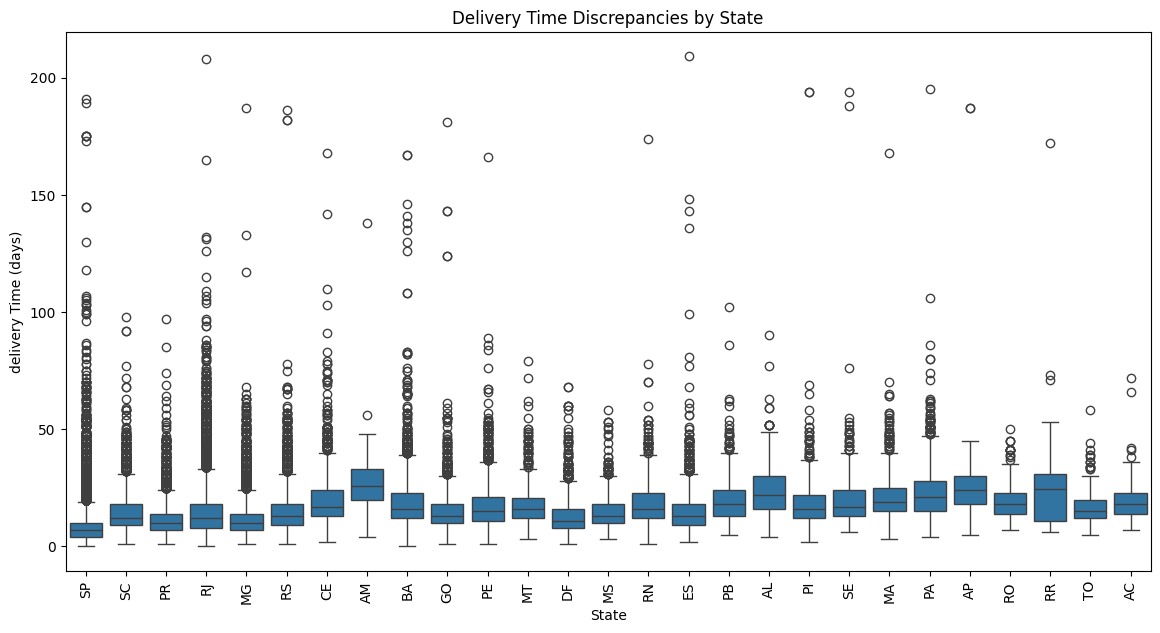

In [10]:
df_train['delivery_time_days'] = (df_train['order_delivered_customer_date'] - df_train['order_purchase_timestamp']).dt.days

plt.figure(figsize=(14,7))
sns.boxplot(data=df_train, x='customer_state', y='delivery_time_days')
plt.title('Delivery Time Discrepancies by State')
plt.xlabel('State')
plt.ylabel('delivery Time (days)')
plt.xticks(rotation=90)
plt.show()

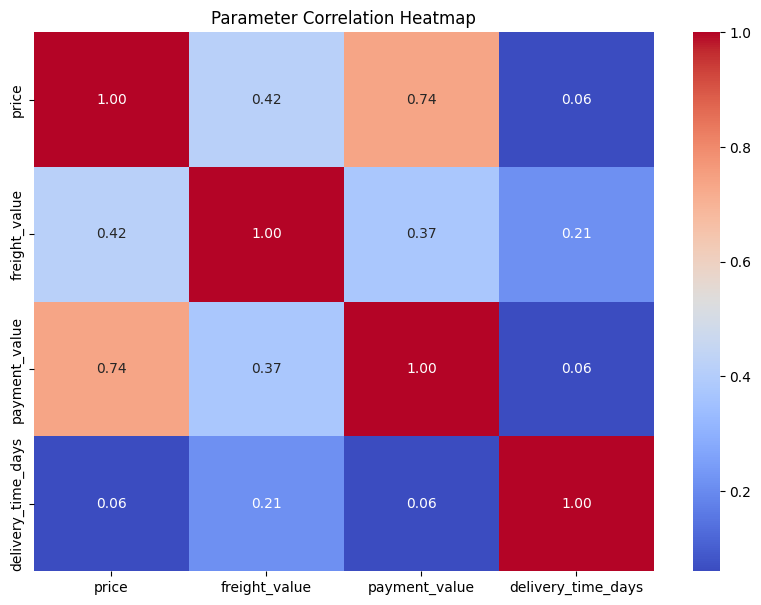

In [11]:
numeric_cols = ['price', 'freight_value', 'payment_value', 'delivery_time_days']

correlation_matrix = df_train[numeric_cols].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Parameter Correlation Heatmap')
plt.show()

## Visualization & Explanatory Analysis

### Pertanyaan 1: How does a delay in shipping (from the carrier to the customer) impact customer satisfaction and review scores?

C:\Users\rizky\AppData\Local\Temp\ipykernel_42048\1130911399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["order_delivered_customer_date"] = pd.to_datetime(data["order_delivered_customer_date"])
C:\Users\rizky\AppData\Local\Temp\ipykernel_42048\1130911399.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["order_delivered_carrier_date"] = pd.to_datetime(data["order_delivered_carrier_date"])
C:\Users\rizky\AppData\Local\Temp\ipykernel_42048\1130911399.py:8: SettingWithCopyWarning: 
A value 

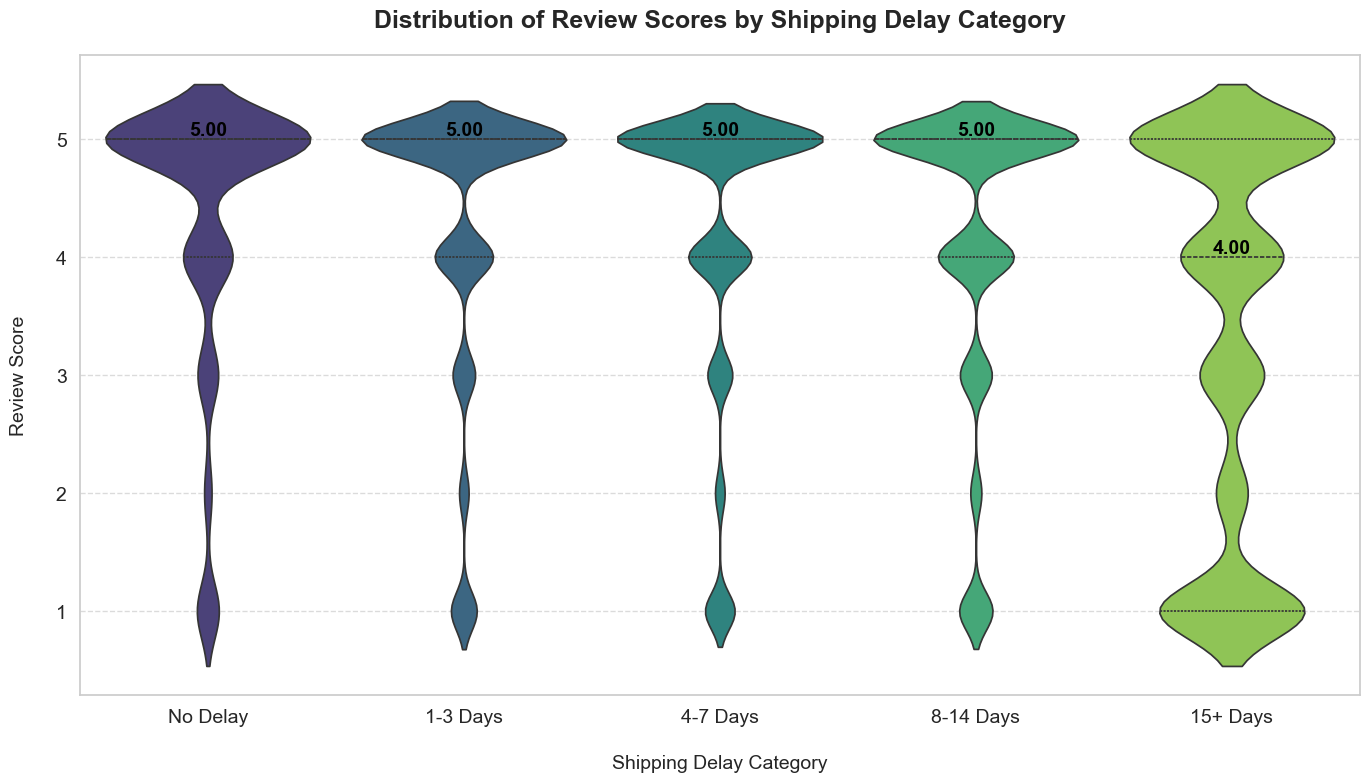

In [12]:
data = df_train[["order_delivered_customer_date", "order_delivered_carrier_date", "review_score"]]

# Convert to datetime
data["order_delivered_customer_date"] = pd.to_datetime(data["order_delivered_customer_date"])
data["order_delivered_carrier_date"] = pd.to_datetime(data["order_delivered_carrier_date"])

# Calculate delay in days
data["delay_days"] = (data["order_delivered_customer_date"] - data["order_delivered_carrier_date"]).dt.days

# Define bins and labels
bins = [-1, 0, 3, 7, 14, float("inf")]
labels = ["No Delay", "1-3 Days", "4-7 Days", "8-14 Days", "15+ Days"]
data["delay_category"] = pd.cut(data["delay_days"], bins=bins, labels=labels)

# Plotting
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

palette = sns.color_palette("viridis", len(labels))

sns.violinplot(x="delay_category", y="review_score", data=data, palette=palette, inner="quartile")
plt.title("Distribution of Review Scores by Shipping Delay Category", fontsize=18, weight="bold", pad=20)
plt.xlabel("Shipping Delay Category", fontsize=14, labelpad=20)
plt.ylabel("Review Score", fontsize=14, labelpad=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate medians
medians = data.groupby("delay_category")["review_score"].median()
for index, median in enumerate(medians):
    plt.text(index, median, f"{median:.2f}", ha="center", va="bottom", fontsize=14, color="black", weight="bold")

plt.tight_layout(pad=4.0)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

plt.show()

In [13]:
df_train.describe()

,order_purchase_timestamp,order_delivered_customer_date,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,...,seller_zip_code_prefix,day_month_year,day_of_week_int,hour,month,year,datetime,day_month_year_delivered,delivery_time,delivery_time_days
count,119143,115722,118310.000000,118310.000000,118310.000000,119140.000000,119140.000000,119140.000000,118146.000000,116601.000000,...,118310.000000,119143,119143.000000,119143.000000,119143.000000,119143.000000,119143,115722,115722.000000,115722.000000
mean,2017-12-29 18:36:13.115760128,2018-01-12 20:55:38.199616256,1.196543,120.646603,20.032387,1.094737,2.941246,172.735135,4.015582,48.767498,...,24442.410413,2017-12-29 03:20:51.024399104,3.745801,14.755537,6.033086,2017.535290,2017-12-29 18:36:13.115760128,2018-01-12 04:12:31.843210240,12.022589,12.022589
min,2016-09-04 21:15:19,2016-10-11 13:46:32,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,5.000000,...,1001.000000,2016-09-04 00:00:00,1.000000,0.000000,1.000000,2016.000000,2016-09-04 21:15:19,2016-10-11 00:00:00,0.000000,0.000000
25%,2017-09-10 20:15:46,2017-09-22 21:54:31.249999872,1.000000,39.900000,13.080000,1.000000,1.000000,60.850000,4.000000,42.000000,...,6429.000000,2017-09-10 00:00:00,2.000000,11.000000,3.000000,2017.000000,2017-09-10 20:15:46,2017-09-22 00:00:00,6.000000,6.000000
50%,2018-01-17 11:59:12,2018-02-01 03:17:55,1.000000,74.900000,16.280000,1.000000,2.000000,108.160000,5.000000,52.000000,...,13660.000000,2018-01-17 00:00:00,4.000000,15.000000,6.000000,2018.000000,2018-01-17 11:59:12,2018-02-01 00:00:00,10.000000,10.000000
75%,2018-05-03 13:18:30,2018-05-15 00:08:31.500000,1.000000,134.900000,21.180000,1.000000,4.000000,189.240000,5.000000,57.000000,...,27972.000000,2018-05-03 00:00:00,5.000000,19.000000,8.000000,2018.000000,2018-05-03 13:18:30,2018-05-14 18:00:00,15.000000,15.000000
max,2018-10-17 17:30:18,2018-10-17 13:22:46,21.000000,6735.000000,409.680000,29.000000,24.000000,13664.080000,5.000000,76.000000,...,99730.000000,2018-10-17 00:00:00,7.000000,23.000000,12.000000,2018.000000,2018-10-17 17:30:18,2018-10-17 00:00:00,209.000000,209.000000
std,NaN,NaN,0.699489,184.109691,15.836850,0.730141,2.777848,267.776077,1.400436,10.033540,...,27573.004511,NaN,1.960525,5.327825,3.233819,0.505591,NaN,NaN,9.454922,9.454922


### Pertanyaan 2: How has the sales revenue evolved over time for different regions, and which regions show the highest growth or decline?

In [14]:
# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = df_geolocation[df_geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_train = df_train.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_train = df_train.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_train.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,delivery_time_days,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,2.0,35,SP,São Paulo,Sudeste,3366.0,-23.568553,-46.537559,sao paulo,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,5.0,35,SP,São Paulo,Sudeste,2290.0,-23.725916,-46.709104,sao paulo,SP


In [15]:
category_translation_2 = {
    'Norte': 'North',
    'Sudeste': 'Southeast',
    'Sul': 'South',
    'Centro-Oeste	': 'West',
    'Nordeste': 'Northeast',
    'Sudoeste': 'Southwest',
    'Noroeste': 'Northwest'}

df_train['nome_regiao'] = df_train['nome_regiao'].replace(category_translation_2)

# Grouping data by region
df_regions_group = df_train.groupby(by=['month_year', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='month_year')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)
df_regions_group.head()

,month,region,order_count,order_amount
0,2016 09,North,2,72.89
1,2016 09,South,1,59.50
2,2016 09,Southeast,4,134.97
3,2016 10,Centro-Oeste,22,2435.85
4,2016 10,North,7,1127.30


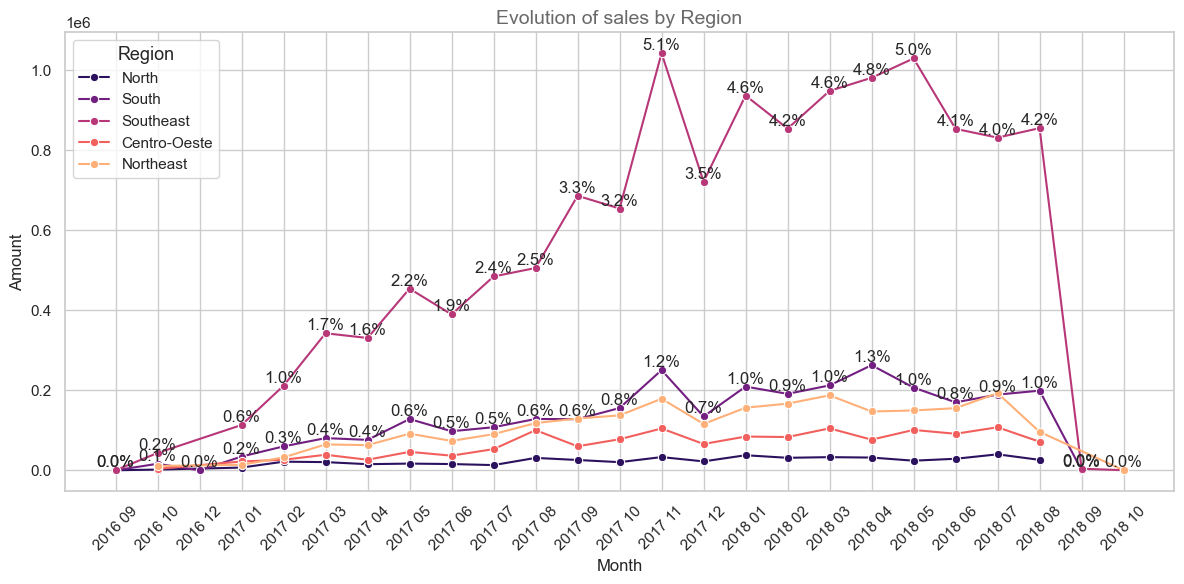

In [16]:
df_regions_group = df_train.groupby(by=['month_year', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'payment_value': 'sum'}).sort_values(by='month_year')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='order_amount', hue='region', data=df_regions_group, palette='magma', marker='o')

highlight_regions = ['South', 'Southeast']  
total_orders = df_regions_group['order_amount'].sum()

for region in df_regions_group['region'].unique():
    region_data = df_regions_group[df_regions_group['region'] == region]
    for i in range(len(region_data)):
        if region in highlight_regions:  
            percentage = (region_data['order_amount'].iloc[i] / total_orders) * 100
            plt.text(x=region_data['month'].iloc[i], 
                     y=region_data['order_amount'].iloc[i], 
                     s=f'{percentage:.1f}%', 
                     ha='center', va='bottom')

plt.title('Evolution of sales by Region', size=14, color='dimgrey')
plt.xlabel('Month', size=12)
plt.ylabel('Amount')
plt.xticks(rotation=45) 
plt.legend(title='Region', title_fontsize='13', fontsize='11')

plt.tight_layout() 
plt.show()

### Pertanyaan 3: Which areas have the highest incidence of delivery delays?

In [17]:
# Convert to datetime
data = df_train[["order_delivered_customer_date", "order_delivered_carrier_date", "geolocation_lat", "geolocation_lng",'nome_regiao']]
data["order_delivered_customer_date"] = pd.to_datetime(data["order_delivered_customer_date"])
data["order_delivered_carrier_date"] = pd.to_datetime(data["order_delivered_carrier_date"])
df_train["order_delivered_customer_date_new"] = pd.to_datetime(data["order_delivered_customer_date"])
df_train["order_delivered_carrier_date_new"] = pd.to_datetime(data["order_delivered_carrier_date"])

# Calculate delay in days
data["delay_days"] = (data["order_delivered_customer_date"] - data["order_delivered_carrier_date"]).dt.days

# Define bins and labels
bins = [-1, 0, 3, 7, 14, float("inf")]
labels = ["No Delay", "1-3 Days", "4-7 Days", "8-14 Days", "15+ Days"]
data["delay_category"] = pd.cut(data["delay_days"], bins=bins, labels=labels)
# Extract latitude, longitude, and delay category
locations = data[["geolocation_lat", "geolocation_lng", "delay_category"]].dropna().values.tolist()

C:\Users\rizky\AppData\Local\Temp\ipykernel_42048\2493315579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["order_delivered_customer_date"] = pd.to_datetime(data["order_delivered_customer_date"])
C:\Users\rizky\AppData\Local\Temp\ipykernel_42048\2493315579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["order_delivered_carrier_date"] = pd.to_datetime(data["order_delivered_carrier_date"])
C:\Users\rizky\AppData\Local\Temp\ipykernel_42048\2493315579.py:9: SettingWithCopyWarning: 
A value 

In [18]:
# Calculate the total number of orders for each region
total_orders_per_region = df_train.groupby('nome_regiao').size().reset_index(name='total_orders')

# Calculate the number of high delays (4-7 Days) for each region
high_delays_per_region = data.query('delay_category == "4-7 Days"').groupby('nome_regiao').size().reset_index(name='high_delays')

# Merge the two dataframes
region_delay_stats = pd.merge(total_orders_per_region, high_delays_per_region, on='nome_regiao', how='left')

# Calculate the percentage of high delays
region_delay_stats['high_delay_percentage'] = (region_delay_stats['high_delays'] / region_delay_stats['total_orders']) * 100

# Fill NaN values with 0 (in case there are regions with no high delays)
region_delay_stats['high_delays'].fillna(0, inplace=True)
region_delay_stats['high_delay_percentage'].fillna(0, inplace=True)

# Merge the result with df_train
df_train = pd.merge(df_train, region_delay_stats, on='nome_regiao', how='left')

# Display the dataframe
region_delay_stats

,nome_regiao,total_orders,high_delays,high_delay_percentage
0,Centro-Oeste,6976,1899,27.221904
1,North,2165,167,7.713626
2,Northeast,11079,1324,11.950537
3,South,16961,5842,34.443724
4,Southeast,81962,29552,36.055733


In [19]:
#import folium

# Zipping locations
lats = list(data.query('delay_category == "4-7 Days"')['geolocation_lat'].dropna().values)
longs = list(data.query('delay_category == "4-7 Days"')['geolocation_lng'].dropna().values)
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

**Insight:**
- The products with the highest distribution are located in the Southeast and South regions of Brazil, which are home to the largest population densities. For instance, the Southeast region, specifically São Paulo, has a population of approximately 12 million residents.

## Conclusion

### Pertanyaan 1: How does a delay in shipping (from the carrier to the customer) impact customer satisfaction and review scores?


Shipping delays have a significant impact on customer satisfaction and review scores. When shipments are delayed, many customers leave 1-star reviews, highlighting their dissatisfaction. In contrast, orders delivered on time tend to receive much higher ratings, demonstrating how crucial timely delivery is to overall customer experience.

### Pertanyaan 2: How has the sales revenue evolved over time for different regions, and which regions show the highest growth or decline?

1. Sales Growth in the 'Southeast' and 'South' Regions:

- The graph shows that the 'Southeast' region has experienced a significantly higher sales growth compared to other regions. In October 2017, sales in the 'Southeast' reached their peak, contributing over 5% of the total sales.
- The 'South' region also demonstrated a high contribution, with sales peaking in April 2018 at around 5% of total sales.

### Pertanyaan 3: Which areas have the highest incidence of delivery delays?

Based on the data, the Southeast region has the highest percentage of delayed deliveries at 36.06%, followed by the South region at 34.44%. Although the total number of orders in the Southeast region is significantly higher (81,962 orders), the number of delayed deliveries is also substantial, reaching 29,552 orders. The Centro-Oeste region ranks third with a delay percentage of 27.22%. On the other hand, the North and Northeast regions have lower delay rates, at 7.71% and 11.95%, respectively. This indicates that delayed deliveries are more prevalent in the Southeast and South regions.


In [20]:
df_train.to_csv("dashboard/ecommerce.csv", index=False)